<hr style='border-top:4px solid #1F77B4;'>

<h2><span style="color: #1F77B4; font-size: 40px">Chapitre 6</span>  </h2>

<h1><span style="color: #1F77B4; font-size: 60px">Réseaux de neurones récurrents (RNN)</span>  </h1>

<hr style='border-top:4px solid #1F77B4;'>

### Importation des bibliothèques

In [1]:
import numpy                         as np
import pandas                        as pd
import matplotlib.pyplot             as plt
from IPython.display                 import display, HTML, Math, Image
from tensorflow.random               import set_seed
from matplotlib                      import cm
import tensorflow                    as tf
import os
import random

In [2]:
# Définir le Seed pour la reproductibilité
seed_value = 42

# Définir les Seeds pour les différentes bibliothèques
os.environ['PYTHONHASHSEED'] = str(seed_value)  # Assurer la reproductibilité pour le hachage des objets Python
random.seed(seed_value)                         # Seed pour les opérations aléatoires de Python
np.random.seed(seed_value)                      # Seed pour les opérations aléatoires de NumPy
tf.random.set_seed(seed_value)                  # Seed pour les opérations aléatoires de TensorFlow

# Assurer la reproductibilité des comportements internes
os.environ['TF_DETERMINISTIC_OPS'] = '1'   # Force TensorFlow à utiliser des opérations déterministes

<hr style='border-top:4px solid #1F77B4;'>

In [3]:
def save_figure(fig, path):
    # Extraire le répertoire du chemin donné
    directory = os.path.dirname(path)
    
    # Créer le répertoire s'il n'existe pas
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Sauvegarder dans plusieurs formats
    fig.savefig(f"{path}.pdf", format="pdf", bbox_inches='tight')
    fig.savefig(f"{path}.png", format="png", bbox_inches='tight')
    fig.savefig(f"{path}.jpg", format="jpg", bbox_inches='tight')

In [4]:
def data_plot(dataset):
    # Créer la figure et l'axe
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Tracer toutes les données
    ax.plot(dataset.index, dataset["High"], color='blue', label='Toutes les données')
    
    # Titre et labels
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel("High ($USD)", fontsize=14)
    
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    
    ax.grid(True)
    
    return fig

In [5]:
def train_val_test_plot(dataset, tstart, tval, tend):
    # Créer figure et axe
    fig, ax = plt.subplots(figsize=(10, 4))

    # Tracer les données d'entraînement
    dataset.loc[f"{tstart}":f"{tval - 1}", "High"].plot(ax=ax, label=f"Entraînement ({tstart}–{tval - 1})")

    # Tracer les données de validation
    dataset.loc[f"{tval}":f"{tend - 1}", "High"].plot(ax=ax, label=f"Validation ({tval})")

    # Tracer les données de test
    dataset.loc[f"{tend}":, "High"].plot(ax=ax, label=f"Test ({tend} et après)")

    # Légendes et étiquettes
    ax.legend(fontsize=14)
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel("High ($USD)", fontsize=14)
    ax.tick_params(axis='both', labelsize=12, rotation=0)
    ax.grid(True)

    return fig


In [6]:
def plot_predictions(test_set_full, predicted, n_steps, test_dates):
    # Créer figure et axe
    fig, ax = plt.subplots(figsize=(10, 4.5))

    # Tracer toutes les valeurs réelles du test_set avec les vraies dates
    ax.plot(test_dates, test_set_full, ".-", linewidth=2, label="Valeurs réelles")

    # Tracer les prédictions avec le décalage correct (commencent à l'indice n_steps)
    prediction_dates = test_dates[n_steps:n_steps + len(predicted)]
    ax.plot(prediction_dates, predicted, ".-", linewidth=2, label="Valeurs prédites")

    # Étiquettes des axes
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel("High ($USD)", fontsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
    ax.tick_params(axis='y', labelsize=12)

    # Légende
    ax.legend(fontsize=14, loc='upper left')

    # Grille
    ax.grid(True)

    return fig

In [7]:
def compare_predictions(actual, predicted_lstm, predicted_rnn, predicted_gru, prediction_dates):
    # Créer la figure et l'axe
    fig, ax = plt.subplots(figsize=(10, 4.5))

    # Colormap viridis pour couleurs cohérentes
    cmap = plt.colormaps.get_cmap('viridis')

    # Calculer la RMSE pour chaque modèle
    from sklearn.metrics import mean_squared_error
    rmse_lstm = np.sqrt(mean_squared_error(actual, predicted_lstm))
    rmse_rnn  = np.sqrt(mean_squared_error(actual, predicted_rnn))
    rmse_gru  = np.sqrt(mean_squared_error(actual, predicted_gru))

    # Couleurs distinctes
    color_lstm = cmap(0.2)
    color_rnn  = cmap(0.5)
    color_gru  = cmap(0.8)

    # Tracer les valeurs réelles avec les vraies dates
    ax.plot(prediction_dates, actual, ".-", markersize=3, label="Prix réel des actions", color="orange", linewidth=2)

    # Tracer les prédictions avec RMSE dans la légende et vraies dates
    ax.plot(prediction_dates, predicted_lstm, ".-", markersize=3, label=f'Prédictions LSTM (RMSE = {rmse_lstm:.2f})', color=color_lstm)
    ax.plot(prediction_dates, predicted_rnn, ".-", markersize=3, label=f'Prédictions RNN (RMSE = {rmse_rnn:.2f})', color=color_rnn)
    ax.plot(prediction_dates, predicted_gru, ".-", markersize=3, label=f'Prédictions GRU (RMSE = {rmse_gru:.2f})', color=color_gru)

    # Étiquettes et style
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel("High ($USD)", fontsize=14)
    ax.tick_params(axis='x', labelsize=12, rotation=45)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(loc='upper right', fontsize=14)

    ax.grid(True)

    return fig

In [8]:
def return_rmse(actual_stock_price, predicted_stock_price, model_name):
    # Calcule et affiche le RMSE entre les valeurs réelles et prédites
    rmse = np.sqrt(mean_squared_error(actual_stock_price, predicted_stock_price))
    print(f"L'erreur quadratique moyenne du {model_name} est égale à {rmse:.2f}")
    
    return rmse

<hr style='border-top:4px solid #1F77B4;'>

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 6.1 : Lecture des données "mastercard_stock_data_kaggle"</h3>

In [9]:
dataset = pd.read_csv("./Base de données/Mastercard_stock_history.csv", 
                      index_col="Date", parse_dates=["Date"]
                     ).drop(["Dividends", "Stock Splits"], axis=1)
display(dataset)

,Open,High,Low,Close,Volume
Date,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000
...,...,...,...,...,...
2021-10-05,347.121403,348.130138,342.497241,342.776886,4724100
2021-10-06,339.580960,348.439763,338.682072,348.250000,3712000
2021-10-07,349.000000,357.899994,349.000000,353.910004,3209200


<h3><span style="font-size: 30px">🎴</span> Figure 6.1 : Jeu de données sur les actions de Mastercard</h3>

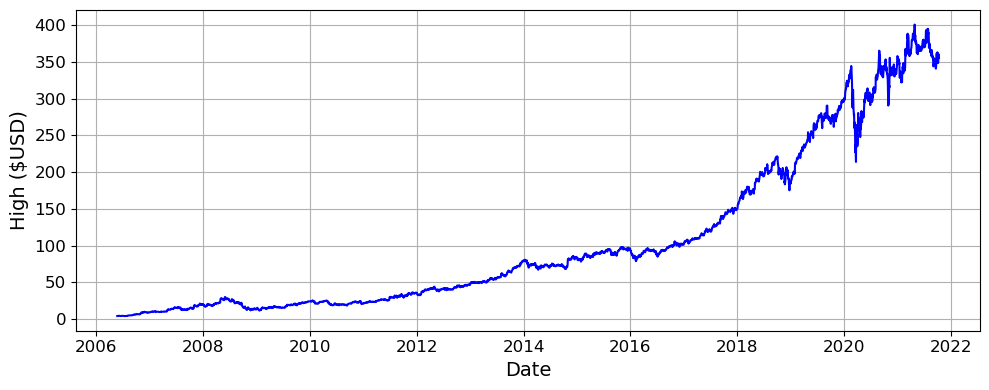

In [10]:
# Tracer et récupérer la figure
fig = data_plot(dataset)

# Optimiser l'affichage
plt.tight_layout()

# Afficher la figure
plt.show()

# Sauvegarder la figure
save_figure(fig, "Figures/Figure_6.1/Chap6_Figure_6.1")


<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 6.2 : Création des sous-ensembles d'entraînement, de validation et de test</h3>

In [11]:
tstart = 2016  # Année de début pour l'entraînement
tval   = 2020  # Année de fin pour la validation
tend   = 2021  # Année de début pour le test

# Jeu d'entraînement : de 2016 à 2020 (excluant 2020)
training_set = dataset.loc[f"{tstart}":f"{tval-1}", "High"].values

# Jeu de validation : de 2020 à 2021 (excluant 2021)
validation_set = dataset.loc[f"{tval}":f"{tend-1}", "High"].values

# Jeu de test : À partir de 2021 et au-delà
test_set = dataset.loc[f"{tend}":, "High"].values

# Récupérer les dates correspondantes au test_set pour l'affichage
test_dates = dataset.loc[f"{tend}":].index

In [12]:
print("=" * 40)
print("Taille des sous-ensembles de données")
print("=" * 40)
print(f"{'sous-ensembles':<15} {'Taille':<15}")
print("-" * 40)
print(f"{'Entrainement':<15} {training_set.shape}")
print(f"{'Validation':<15} {validation_set.shape}")
print(f"{'Test':<15} {test_set.shape}")
print("=" * 40)

Taille des sous-ensembles de données
sous-ensembles  Taille         
----------------------------------------
Entrainement    (1006,)
Validation      (253,)
Test            (195,)


<h3><span style="font-size: 30px">🎴</span> Figure 6.2 : Représentation des trois sous-ensembles (entraînement, validation et test) du jeu de données</h3>

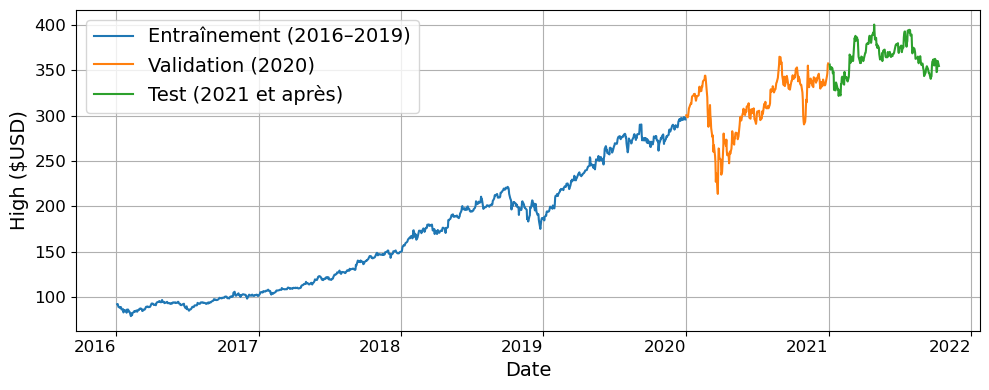

In [13]:
# Tracer et récupérer la figure
fig = train_val_test_plot(dataset, 2016, 2020, 2021)

# Optimiser l'affichage
plt.tight_layout()

# Afficher la figure
plt.show()

# Sauvegarder la figure
save_figure(fig, "Figures/Figure_6.2/Chap6_Figure_6.2")

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 6.3 : Normalisation des données des trois sous-ensembles</h3>

In [14]:
from sklearn.preprocessing import MinMaxScaler

# Initialiser le scaler MinMax avec une échelle de (0, 1)
sc = MinMaxScaler(feature_range=(0, 1))

# Appliquer la transformation MinMax au jeu d'entraînement
training_set_scaled = sc.fit_transform(training_set.reshape(-1, 1))

# Appliquer le même scaler (transformation) aux jeux de validation et de test
validation_set_scaled = sc.transform(validation_set.reshape(-1, 1))
test_set_scaled       = sc.transform(test_set.reshape(-1, 1))

In [15]:
print("=" * 40)
print("Taille des sous-ensembles de données")
print("normalisées")
print("=" * 40)
print(f"{'sous-ensembles':<15} {'Taille':<15}")
print("-" * 40)
print(f"{'Entrainement':<15} {training_set_scaled.shape}")
print(f"{'Validation':<15} {validation_set_scaled.shape}")
print(f"{'Test':<15} {test_set_scaled.shape}")
print("=" * 40)

Taille des sous-ensembles de données
normalisées
sous-ensembles  Taille         
----------------------------------------
Entrainement    (1006, 1)
Validation      (253, 1)
Test            (195, 1)


<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 6.4 : Fonction de découpage d'une séquence en fenêtres (split_sequence)</h3>

In [16]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()

    # Parcourir la séquence pour créer des sous-séquences
    for i in range(len(sequence)):
        # Définir l'indice de fin de la sous-séquence
        end_ix = i + n_steps

        # Vérifier si l'indice de fin dépasse la longueur de la séquence
        if end_ix > len(sequence) - 1:
            break

        # Créer la sous-séquence (features) et la valeur cible correspondante
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]

        # Ajouter la sous-séquence et la valeur cible aux listes X et y
        X.append(seq_x)
        y.append(seq_y)

    # Convertir les listes en tableaux NumPy et les retourner
    return np.array(X), np.array(y)

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 6.5 : Création des séquences</h3>

In [17]:
n_steps  = 60  # 60 jours par séquence
features = 1   # Une seule caractéristique (prix des actions)

# Jeu d'entraînement 
X_train, y_train = split_sequence(training_set_scaled, n_steps)

# Jeu de validation 
X_val, y_val = split_sequence(validation_set_scaled, n_steps)

# Jeu de test 
X_test, y_test = split_sequence(test_set_scaled, n_steps)

In [18]:
print("=" * 40)
print("Taille des sous-ensembles de données")
print("suite à la formation des séquences")
print("=" * 40)
print(f"{'sous-ensembles':<15} {'Taille':<15}")
print("-" * 40)
print(f"{'Entrainement':<15} {X_train.shape}")
print(f"{'Validation':<15} {X_val.shape}")
print(f"{'Test':<15} {X_test.shape}")
print("=" * 40)

Taille des sous-ensembles de données
suite à la formation des séquences
sous-ensembles  Taille         
----------------------------------------
Entrainement    (946, 60, 1)
Validation      (193, 60, 1)
Test            (135, 60, 1)


<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 6.6 : Création d'un modèle séquentiel avec une couche récurrente</h3>

In [19]:
tf.keras.backend.clear_session()

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.optimizers import SGD, RMSprop

# Définir le modèle RNN en utilisant l'API Séquentielle de Keras
model_rnn = Sequential()

# Ajouter une couche récurrente SimpleRNN avec 125 unités
model_rnn.add(SimpleRNN(units=125, activation="tanh",
                        input_shape=(n_steps, features)))

# Ajouter une couche Dropout avec un taux de 20% pour régulariser le modèle
model_rnn.add(Dropout(0.2, seed=seed_value))

# Ajouter une couche de sortie dense avec 1 seule unité
# Convient aux tâches de régression (prédiction d'une valeur continue)
model_rnn.add(Dense(units=1))

# Définir le taux d'apprentissage et l'optimiseur RMSprop
learning_rate = 0.0001
optimizer = RMSprop(learning_rate=learning_rate)

# Compiler le modèle en spécifiant l'optimiseur et la fonction de perte
model_rnn.compile(optimizer=optimizer, loss="mse")

# Afficher un résumé de larchitecture du modèle
model_rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 125)            │        15,875 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,001 (62.50 KB)

 Trainable params: 16,001 (62.50 KB)

 Non-trainable params: 0 (0.00 B)

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 6.7 : Entrainement du modèle RNN</h3>

In [21]:
history_rnn = model_rnn.fit(X_train, y_train, 
                            epochs=100,          # Nombre d'époques
                            batch_size=32,       # Taille du batch
                            validation_data=(X_val, y_val)) 

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1133 - val_loss: 0.0439
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - val_loss: 0.0188
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0121 - val_loss: 0.0112
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - val_loss: 0.0112
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0063 - val_loss: 0.0223
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0192
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0054
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 0.0071
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030 - val_loss: 0.0079
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.6706e-04 - val_loss: 0.0016
Epoch 70/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.6155e-04 - val_loss: 0.0019
Epoch 71/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.5160e-04 - val_loss: 0.0015
Epoch 72/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.5286e-04 - val_loss: 0.0022
Epoch 73/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.3910e-04 - val_loss: 0.0014
Epoch 74/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.2330e-04 - val_loss: 0.0017
Epoch 75/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.6200e-04 - val_loss: 0.0016
Epoch 76/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.9110e-04 - val_loss: 0.0020
Epoch 77/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.7130e-04 - val_loss: 0.0031
Epoch 78/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.2129e-04 - val_loss: 0.0013
Epoch 79/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.3130e-04 - val_loss: 0.0013
Epoch 80/100
30/30 ━━━━

<h3><span style="font-size: 30px">🎴</span> Figure 6.10 : Courbe de perte sur les données d'entraînement et de validation</h3>

In [22]:
def plot_learning_curves(history):
    # Créer une figure et un axe
    fig, ax = plt.subplots(figsize=(12, 6))

    # Tracer les courbes de perte
    ax.plot(history.history['loss'], ".-", label="Perte d'entraînement", linewidth=2)
    ax.plot(history.history['val_loss'], ".-", label="Perte de validation", linewidth=2)

    # Ajouter les étiquettes
    ax.set_xlabel("Époques", fontsize=20)
    ax.set_ylabel("Perte (Loss)", fontsize=20)
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.legend(fontsize=22)
    ax.grid(True)

    return fig

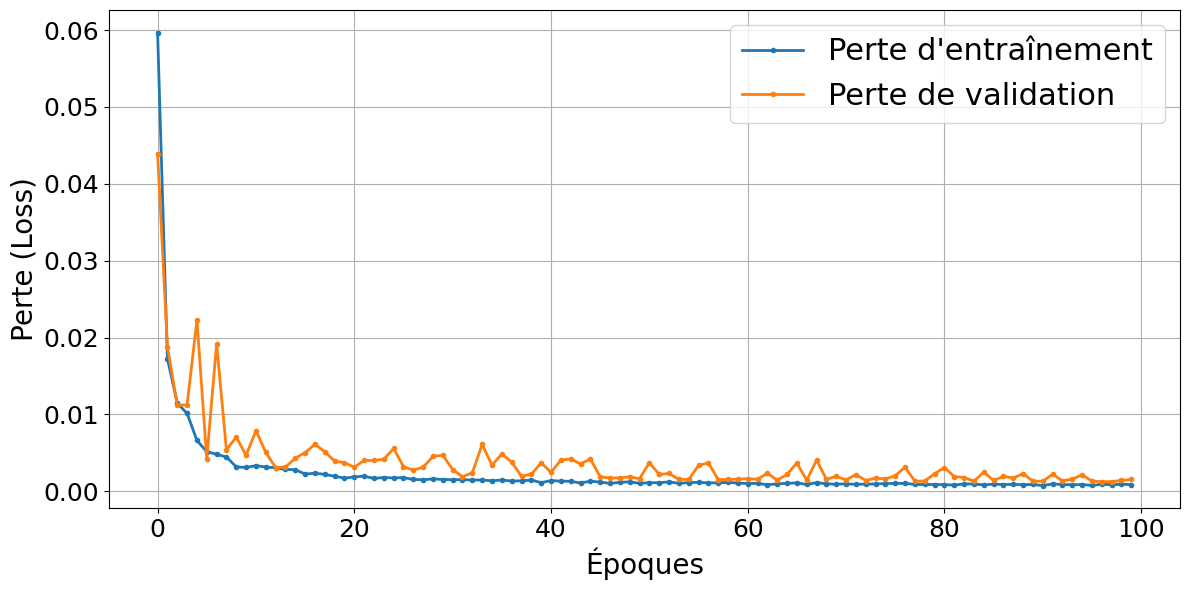

In [23]:
# Tracer et récupérer la figure
fig = plot_learning_curves(history_rnn)

# Optimiser l'affichage
plt.tight_layout()

# Afficher la figure
plt.show()

# Sauvegarder la figure
save_figure(fig, "Figures/Figure_6.10/Chap6_Figure_6.10")

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 6.8 : Test du modèle RNN</h3>

In [24]:
# Utilisation du modèle RNN pour les prédictions
predicted_stock_price_rnn = model_rnn.predict(X_test)

# Appliquer l'inverse de la transformation pour obtenir les valeurs originales
predicted_stock_price_rnn = sc.inverse_transform(predicted_stock_price_rnn)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<h3><span style="font-size: 30px">🎴</span> Figure 6.11 : Prédiction des prix des actions en utilisant un modèle RNN</h3>

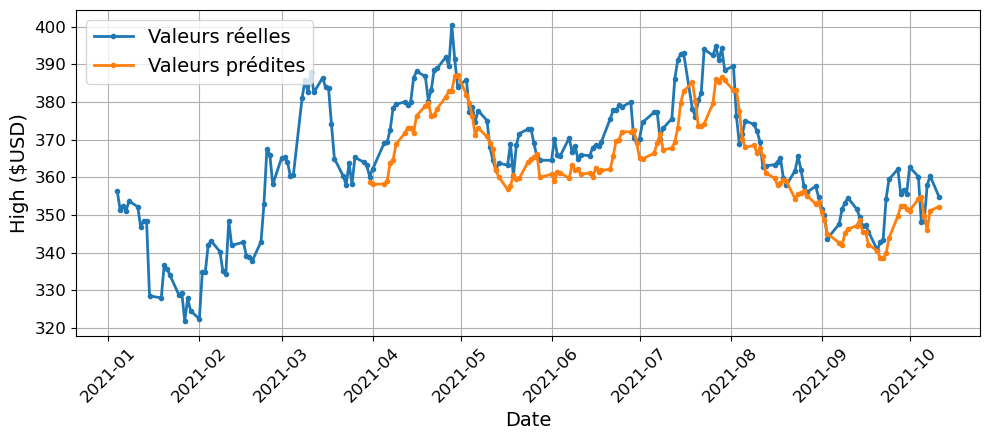

In [25]:
# Visualisation avec déphasage correct et vraies dates : 
# - Valeurs réelles : tout le test_set avec les dates de 2021
# - Prédictions : commencent à la 60ème date (car les 60 premiers jours servent d'entrée)

# Tracer et récupérer la figure
fig = plot_predictions(test_set, predicted_stock_price_rnn.flatten(), n_steps, test_dates)

# Optimiser l'affichage
plt.tight_layout()

# Afficher la figure
plt.show()

# Sauvegarder la figure
save_figure(fig, "Figures/Figure_6.11/Chap6_Figure_6.11")

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 6.9 : Évaluation de la Performance par l'Erreur Quadratique Moyenne (RMSE)</h3>

In [26]:
from sklearn.metrics import mean_squared_error

# Pour le calcul RMSE, utiliser les valeurs correspondantes (jours 60 à 194)
actual_stock_price = test_set[n_steps:]
rmse = np.sqrt(mean_squared_error(actual_stock_price, predicted_stock_price_rnn))
print(f"L'erreur quadratique moyenne du RNN simple est égale à {rmse:.2f}")

L'erreur quadratique moyenne du RNN simple est égale à 7.76


<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 6.10 : Développement d'un modèle LSTM</h3>

In [27]:
from tensorflow.keras.layers import LSTM

tf.keras.backend.clear_session()

# Définir le modèle LSTM en utilisant l'API Séquentielle de Keras
model_lstm = Sequential()

# Ajouter une couche LSTM avec 125 unités (cellules mémoire)
model_lstm.add(LSTM(units=125, 
                    activation="tanh", 
                    input_shape=(n_steps, features)))

# Ajouter une couche Dropout avec un taux de 20 %
model_lstm.add(Dropout(0.2, seed=seed_value))   

# Ajouter une couche Dense avec 1 seule unité en sortie
model_lstm.add(Dense(units=1))   

# Définir l'optimiseur RMSprop avec un taux d'apprentissage très faible
learning_rate = 0.0001
optimizer = RMSprop(learning_rate=learning_rate)

# Compiler le modèle en spécifiant l'optimiseur et la fonction de perte
model_lstm.compile(optimizer=optimizer, loss="mse")

# Afficher un résumé de l'architecture du modèle
model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 125)            │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 6.11 : Entraînement, prédiction et évaluation du modèle LSTM</h3>

In [28]:
# Entraîner le modèle LSTM
history_lstm = model_lstm.fit(X_train, y_train, 
                              epochs=100,          # Nombre d'époques
                              batch_size=32,       # Taille du batch
                              validation_data=(X_val, y_val))  

# Utiliser le modèle lstm pour les prédictions
predicted_stock_price_lstm = model_lstm.predict(X_test)

# Appliquer l'inverse de la transformation pour obtenir les valeurs originales
predicted_stock_price_lstm = sc.inverse_transform(predicted_stock_price_lstm)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.1671 - val_loss: 0.2281
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0183 - val_loss: 0.0210
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0040 - val_loss: 0.0066
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0025 - val_loss: 0.0078
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0022 - val_loss: 0.0078
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0019 - val_loss: 0.0062
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 69/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.4080e-04 - val_loss: 0.0032
Epoch 70/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010 - val_loss: 0.0037
Epoch 71/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 72/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.2600e-04 - val_loss: 0.0030
Epoch 73/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.2161e-04 - val_loss: 0.0034
Epoch 74/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.4961e-04 - val_loss: 0.0027
Epoch 75/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.3641e-04 - val_loss: 0.0028
Epoch 76/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.5132e-04 - val_loss: 0.0034
Epoch 77/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010 - val_loss: 0.0034
Epoch 78/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 8.1089e-04 - val_loss: 0.0027
Epoch 79/100
30/30 ━━━━━━━━━

In [29]:
rmse = np.sqrt(mean_squared_error(actual_stock_price, predicted_stock_price_lstm))
print(f"L'erreur quadratique moyenne du LSTM est égale à {rmse:.2f}")

L'erreur quadratique moyenne du LSTM est égale à 8.06


<h3><span style="font-size: 30px">🎴</span> Figure 6.14 : Prédiction des prix des actions en utilisant un modèle LSTM</h3>

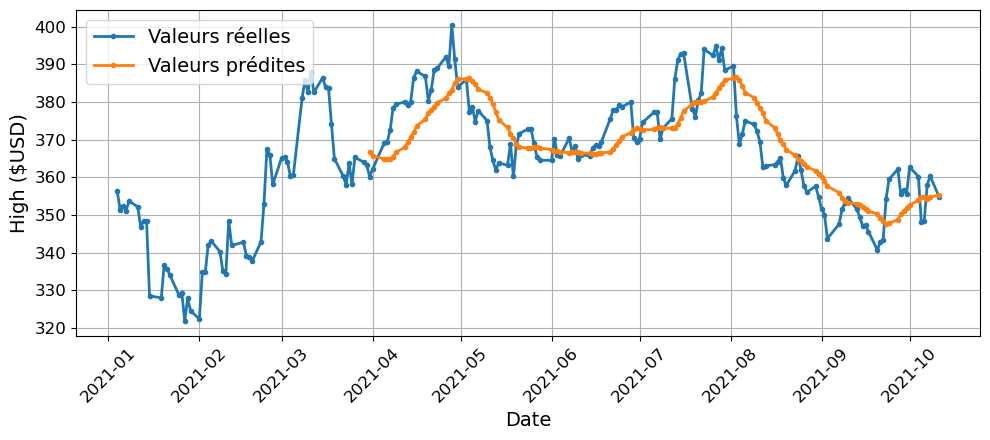

In [30]:
# Visualisation avec déphasage correct et vraies dates pour LSTM
# Tracer et récupérer la figure
fig = plot_predictions(test_set, predicted_stock_price_lstm.flatten(), n_steps, test_dates)

# Optimiser l'affichage
plt.tight_layout()

# Afficher la figure
plt.show()

# Sauvegarder la figure
save_figure(fig, "Figures/Figure_6.14/Chap6_Figure_6.14")

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 6.12 : Création du GRU</h3>

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

# Nettoyage de la session
tf.keras.backend.clear_session()

# Paramètres reproductibles
seed_value = 42

# Définir le modèle GRU en utilisant l'API Séquentielle de Keras
model_gru = Sequential()

# Ajouter une couche GRU avec 125 unités (cellules récurrentes)
model_gru.add(GRU(units=125, activation="tanh", 
                  input_shape=(n_steps, features)))

# Ajout d'un Dropout pour régulariser
model_gru.add(Dropout(0.2, seed=seed_value))

# Ajouter une couche Dense avec une seule unité de sortie
model_gru.add(Dense(units=1))

# Définir l'optimiseur avec un taux d'apprentissage personnalisé
optimizer = RMSprop(learning_rate=0.0001)

# Compilation du modèle
model_gru.compile(optimizer=optimizer, loss="mse")

# Afficher le résumé
model_gru.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 125)            │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

<h3><span style="font-size: 30px">&#128187;</span> Extrait de code 6.13 : Entraînement, prédiction et évaluation du modèle GRU</h3>

In [32]:
# Entraîner le modèle GRU
history_gru = model_gru.fit(X_train, y_train, 
                            epochs=100,          # Nombre d'époques
                            batch_size=32,       # Taille du batch
                            validation_data=(X_val, y_val))  
  
# Utilisation du modèle GRU pour les prédictions
predicted_stock_price_gru = model_gru.predict(X_test)

# Appliquer l'inverse de la transformation pour obtenir les valeurs originales
predicted_stock_price_gru = sc.inverse_transform(predicted_stock_price_gru)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1984 - val_loss: 0.5218
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0665 - val_loss: 0.1642
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0179 - val_loss: 0.0430
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0095 - val_loss: 0.0196
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0036 - val_loss: 0.0085
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.5393e-04 - val_loss: 0.0020
Epoch 68/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.0037e-04 - val_loss: 0.0020
Epoch 69/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.0383e-04 - val_loss: 0.0020
Epoch 70/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.7269e-04 - val_loss: 0.0023
Epoch 71/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.7947e-04 - val_loss: 0.0020
Epoch 72/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.9891e-04 - val_loss: 0.0022
Epoch 73/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.1564e-04 - val_loss: 0.0020
Epoch 74/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.3106e-04 - val_loss: 0.0020
Epoch 75/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.2635e-04 - val_loss: 0.0019
Epoch 76/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.8137e-04 - val_loss: 0.0020
Epoch 77/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.2522e-04 - val_loss: 0.0020
Epoch 78/100

#### Calcul de l'Erreur Quadratique Moyenne (RMSE) du GRU

In [33]:
rmse = np.sqrt(mean_squared_error(actual_stock_price, predicted_stock_price_gru))
print(f"L'erreur quadratique moyenne du GRU est égale à {rmse:.2f}")

L'erreur quadratique moyenne du GRU est égale à 6.57


<h3><span style="font-size: 30px">🎴</span> Figure 6.16 : Prédiction des prix des actions en utilisant un modèle GRU</h3>

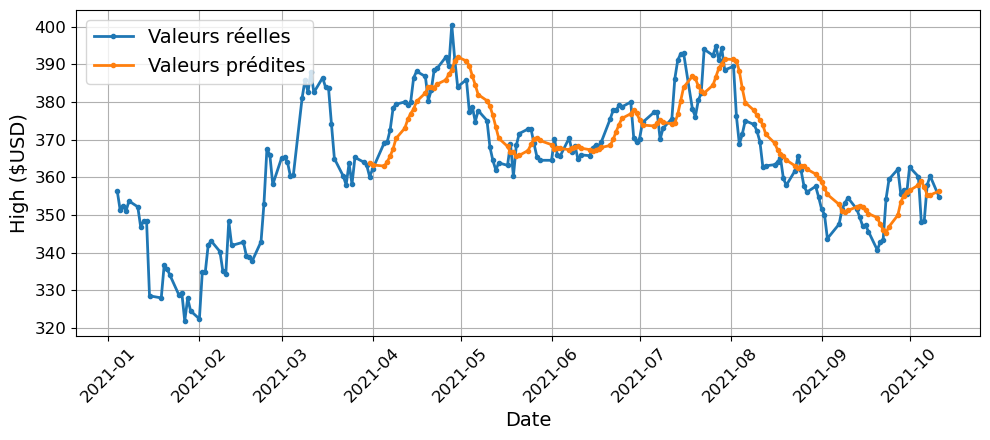

In [34]:
# Visualisation avec déphasage correct et vraies dates pour GRU
# Tracer et récupérer la figure
fig = plot_predictions(test_set, predicted_stock_price_gru.flatten(), n_steps, test_dates)

# Optimiser l'affichage
plt.tight_layout()

# Afficher la figure
plt.show()

# Sauvegarder la figure
save_figure(fig, "Figures/Figure_6.16/Chap6_Figure_6.16")

<h3><span style="font-size: 30px">🎴</span> Figure 6.17 : les données de test (en orange), les  données de test prédites avec un LSTM (en bleu) et les données prédites avec un GRU (en rouge)</h3>

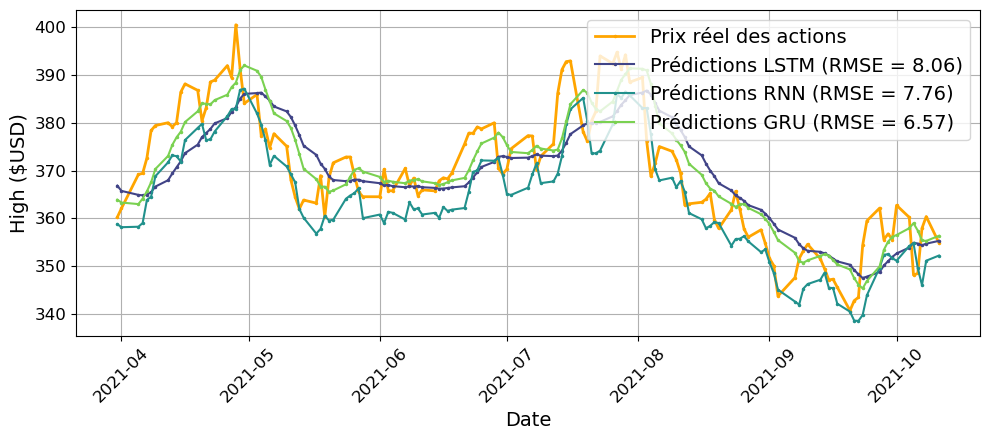

In [35]:
# Alignement correct pour la comparaison finale avec vraies dates
actual_stock_price = test_set[n_steps:]
prediction_dates = test_dates[n_steps:n_steps + len(actual_stock_price)]

# Tracer et récupérer la figure
fig = compare_predictions(actual_stock_price, 
                          predicted_stock_price_lstm.flatten(), 
                          predicted_stock_price_rnn.flatten(), 
                          predicted_stock_price_gru.flatten(),
                          prediction_dates)

# Optimiser l'affichage
plt.tight_layout()

# Afficher la figure
plt.show()

# Sauvegarder la figure
save_figure(fig, "Figures/Figure_6.17/Chap6_Figure_6.17")

<hr style='border-top:4px solid #1F77B4;'>